# 3D Conformation Prediction

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import torch
import torch.nn.functional as F
from tqdm import tqdm
from rdkit.Chem import MolFromSmiles

/home/sebastian/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/sebastian/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sebastian/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) 

## Load QM9

In [104]:
file_re = os.path.join('./qm92', '*.xyz')
file_pathes = glob.glob(file_re)
file_pathes.sort()
ls = []
_smiles_column_names = ['smiles1', 'smiles2']
_label_names = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2',
                'zpve', 'U0', 'U', 'H', 'G', 'Cv']

y = []
for path in tqdm(file_pathes):
    with open(path, 'r') as f:
        data = [line.strip() for line in f]
        
    num_atom = int(data[0])
    properties = list(map(float, data[1].split('\t')[1:]))
    for ix_pos in range(2,num_atom+2):
        y.append(list(map(float, data[ix_pos].replabce('*^', 'e').split('\t')[1:]))[:3])

    smiles = data[3 + num_atom].split('\t')
    new_ls = smiles + properties
    ls.append(new_ls)

df = pd.DataFrame(ls, columns=_smiles_column_names + _label_names)

100%|██████████| 133885/133885 [00:07<00:00, 17865.41it/s]


In [3]:
df.sample(5)

,smiles1,smiles2,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
29448,CC1=CNC2=C1C=CN2,Cc1c[nH]c2c1cc[nH]2,3.27238,1.60102,1.08224,3.1268,81.46,-0.1744,0.0510,0.2254,1082.3535,0.137925,-380.919684,-380.911277,-380.910333,-380.952982,31.189
117154,CCC(O)C(=O)COC,CC[C@@H](O)C(=O)COC,2.37554,1.04248,0.82763,2.0751,76.33,-0.2494,-0.0401,0.2093,1477.5839,0.179232,-461.365249,-461.354321,-461.353377,-461.402338,38.054
78765,CC1C2C3C2(O)CC13O,C[C@H]1[C@@H]2[C@H]3[C@]2(O)C[C@@]13O,2.51009,1.56975,1.26651,2.3262,74.72,-0.2392,0.0699,0.3091,1065.3161,0.157432,-422.970680,-422.962001,-422.961057,-423.003306,34.200
40246,C1NC11CCCN2CC12,C1N[C@]21CCCN1C[C@@H]21,2.71963,1.60011,1.22138,1.3324,82.28,-0.2167,0.0800,0.2967,1089.0067,0.185673,-383.225541,-383.217837,-383.216893,-383.257530,31.391
75106,NC1=NCC(=O)NC1=O,NC1=NCC(=O)NC1=O,3.12381,1.45091,0.99707,2.1045,66.49,-0.2469,-0.0596,0.1873,1090.6439,0.102715,-470.092168,-470.084333,-470.083388,-470.124831,29.101


# Setting up dataset

The first thing we want to do is to find a way of representing a molecule to our graph convolutional network. For this, we will make use of DeepChem which provides a number of 'featurizers'. In this case the features of an atom is a number of descriptors generated from RDKit.

In [143]:
mols = [MolFromSmiles(row.smiles1) for (ix,row) in df.iterrows()]
data_list = []

In [68]:
import networkx as nx

def create_edge_index(A):
    rows = []
    cols = []
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if A[i,j] == 1:
                rows.append(i)
                cols.append(j)
    return rows, cols

def get_molecule_features(m):
    featurizer = ConvMolFeaturizer()
    return featurizer.featurize([m])[0].get_atom_features()

In [106]:
from deepchem.feat import RDKitDescriptors, ConvMolFeaturizer
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

m = mols[50]
molecule_featurized = get_molecule_features(m)
A = GetAdjacencyMatrix(m)

Let's see how our adjacency matrix looks. This matrix will be used in our graph convolutions.

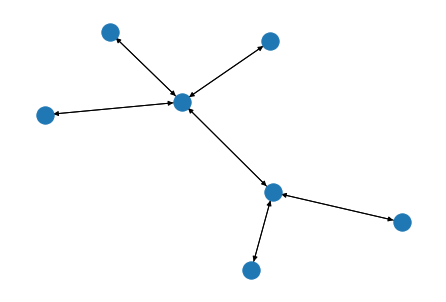

In [13]:
D = nx.to_networkx_graph(A,create_using=nx.DiGraph())
nx.draw(D)

Let's see how the molecule looks in 2D according to RDKit

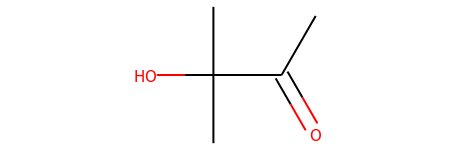

In [14]:
from rdkit.Chem import Draw
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import IPythonConsole
m

Let's repeat this for all molecules

In [ ]:
from torch_geometric.data import Data, DataLoader
from torchvision import transforms
data_list = []
featurizer = RDKitDescriptors()

for ix, m in enumerate(mols):
    mol_featurized = get_molecule_features(m)
    A = GetAdjacencyMatrix(m)
    edge_index = create_edge_index(A)
    x = torch.tensor(mol_featurized)
    x_min = torch.min(x)
    range_x = torch.max(x) - torch.min(x)
    x = (x - x_min) / range_x
    d = Data(x=x, edge_index=torch.LongTensor(edge_index), y=torch.tensor(y[ix]))
    data_list.append(d)

In [ ]:
loader = DataLoader(data_list, batch_size=32)

In [135]:
loader.dataset[0]

Data(edge_index=[2, 14], x=[7, 75], y=[3])

# Setting Up Graph Convolutional Network

In [118]:
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(75, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [119]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = loader.dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [120]:
model.double()
model.train()
for epoch in range(1):
    optimizer.zero_grad()
    out = model(data)
    print(out)
    print(y[0])
    #loss = F.nll_loss(out, torch.long(3))
    #loss.backward()
    #optimizer.step()

tensor([[-1.1205, -1.1731, -1.0092],
        [-1.1014, -1.1832, -1.0181],
        [-1.0497, -1.1724, -1.0779],
        [-1.0788, -1.1516, -1.0675],
        [-1.1006, -1.1437, -1.0536],
        [-1.1220, -1.1450, -1.0323],
        [-1.1193, -1.1254, -1.0527]], device='cuda:0', dtype=torch.float64,
       grad_fn=<LogSoftmaxBackward>)
[-0.0126981359, 1.0858041578, 0.0080009958]


In [ ]:
§